## TP1 Aprendizaje profundo

In [19]:
from PIL import Image
import os

def cargar_imagen_en_binario(ruta):
    """
    Abre una imagen en modo 1-bit y la convierte en una matriz de 0 y 1.
    """
    image = Image.open(ruta).convert("1")
    width, height = image.size
    matriz = []
    for y in range(height):
        fila = []
        for x in range(width):
            pixel = image.getpixel((x, y))
            fila.append(1 if pixel == 255 else 0)
        matriz.append(fila)
    return matriz

def cargar_patrones_desde_carpeta(carpeta):
    """
    Carga todas las imágenes .bmp de una carpeta como patrones en binario (0 y 1).
    """
    archivos_bmp = [f for f in os.listdir(carpeta) if f.endswith(".bmp")]
    patrones = []
    for archivo in archivos_bmp:
        ruta_completa = os.path.join(carpeta, archivo)
        patron = cargar_imagen_en_binario(ruta_completa)
        print(f"{archivo} - tamaño: {len(patron[0])}x{len(patron)}")
        patrones.append(patron)
    print(f"Se cargaron {len(patrones)} patrones de {len(patrones[0])} filas y {len(patrones[0][0])} columnas cada uno.")
    return patrones


### Vectorización y normalización de patrones

En esta etapa se toma cada imagen cargada como una matriz binaria (valores `0` y `1`) y se convierte en un vector unidimensional con valores `-1` y `1`. Esta transformación es necesaria porque la red de Hopfield representa cada patrón como un vector de activaciones, donde los valores deben estar centrados en torno al cero para cumplir con los fundamentos del modelo.

Primero, cada valor `0` se transforma en `-1`, y cada `1` se mantiene. Luego, la matriz bidimensional de la imagen se aplana en un solo vector, lo que permite operar con productos exteriores y aplicar dinámicas de red en forma vectorial.

Este paso asegura que los patrones estén en el formato correcto para entrenar la red y realizar recuperaciones.


In [20]:
def centrar_y_vectorizar_patrones(patrones):
    """
    Transforma una lista de matrices binarias (0/1) en una lista de vectores unidimensionales con valores -1/1.
    """
    patrones_vectorizados = []
    for patron in patrones:
        # Centrar sobre cero: 0 → -1, 1 → 1
        for i in range(len(patron)):
            for j in range(len(patron[i])):
                patron[i][j] = patron[i][j] * 2 - 1
        # Aplanar
        patron_vector = [valor for fila in patron for valor in fila]
        patrones_vectorizados.append(patron_vector)
    
    print(f"Tengo {len(patrones_vectorizados)} patrones vectorizados de {len(patrones_vectorizados[0])} elementos cada uno.")
    return patrones_vectorizados


carpeta_imagenes = "imagenes/50x50"
patrones = cargar_patrones_desde_carpeta(carpeta_imagenes)
patrones_vectorizados = centrar_y_vectorizar_patrones(patrones)

print("Tengo " + str(len(patrones_vectorizados)) + " patrones vectorizados de " + str(len(patrones_vectorizados[0])) + " elementos cada uno.")

panda.bmp - tamaño: 50x50
v.bmp - tamaño: 50x50
perro.bmp - tamaño: 50x50
Se cargaron 3 patrones de 50 filas y 50 columnas cada uno.
Tengo 3 patrones vectorizados de 2500 elementos cada uno.
Tengo 3 patrones vectorizados de 2500 elementos cada uno.


### Inicialización de la matriz de pesos

Antes de entrenar la red de Hopfield, se debe crear la matriz de pesos sinápticos `W`, que define las conexiones entre neuronas. Esta matriz es cuadrada y tiene dimensiones `N × N`, donde `N` es la cantidad total de píxeles (o neuronas) por patrón.

Inicialmente, todos los pesos se establecen en cero, y luego se actualizarán mediante la regla de Hebb durante el entrenamiento. Esta matriz almacena el conocimiento aprendido por la red.


In [21]:
def inicializar_matriz_pesos(dimension):
    """
    Inicializa una matriz cuadrada de pesos de tamaño NxN con ceros.
    """
    return [[0 for _ in range(dimension)] for _ in range(dimension)]

ancho = 50
alto = 50
dimension = ancho * alto  # 2700

pesos = inicializar_matriz_pesos(dimension)
print(f"mis pesos tienen la dimensión: {len(pesos)}x{len(pesos[0])}")

mis pesos tienen la dimensión: 2500x2500


In [22]:
def entrenar_red_hopfield(patrones_vectorizados):
    """
    Entrena una red de Hopfield con patrones vectorizados de -1 y 1.
    Retorna la matriz de pesos de tamaño NxN.
    """
    n = len(patrones_vectorizados[0])  # dimensión del vector (por ejemplo, 2700)
    pesos = [[0 for _ in range(n)] for _ in range(n)]
    
    for i_peso in range(n):
        for j_peso in range(n):
            for patron in patrones_vectorizados:
                pesos[i_peso][j_peso] += patron[i_peso] * patron[j_peso]
            pesos[i_peso][j_peso] /= len(patrones_vectorizados)
    
    # Eliminar autoconexiones
    for i in range(n):
        pesos[i][i] = 0

    return pesos


pesos = entrenar_red_hopfield(patrones_vectorizados)
print(f"Matriz de pesos entrenada con tamaño: {len(pesos)}x{len(pesos[0])}")


Matriz de pesos entrenada con tamaño: 2500x2500


### Entrenamiento de la red de Hopfield

La red de Hopfield se entrena utilizando la **regla de Hebb**, una regla de aprendizaje no supervisado que refuerza las conexiones entre neuronas que se activan simultáneamente. En esta implementación, se recorren todos los patrones vectorizados y se calcula la **suma de los productos exteriores** de cada patrón consigo mismo.

El resultado es una matriz de pesos sinápticos que almacena la información de los patrones aprendidos. Finalmente, se eliminan las autoconexiones (valores en la diagonal) ya que una neurona no debe influenciarse a sí misma.

Esta matriz será utilizada para recuperar patrones a partir de entradas ruidosas o incompletas.


In [23]:
import random

def recuperar_patron(patron_inicial, pesos, max_iter=100):
    """
    Recupera un patrón aplicando actualización asíncrona hasta converger.
    """
    n = len(patron_inicial)
    estado = patron_inicial.copy()

    for _ in range(max_iter):
        indices = list(range(n))
        random.shuffle(indices)  # actualización asíncrona

        cambio = False
        for i in indices:
            suma = sum(pesos[i][j] * estado[j] for j in range(n))
            nuevo_valor = 1 if suma >= 0 else -1
            if estado[i] != nuevo_valor:
                estado[i] = nuevo_valor
                cambio = True

        if not cambio:
            break  # convergió

    return estado


In [24]:
import matplotlib.pyplot as plt
import numpy as np

def mostrar_comparacion_patron(original, recuperado, ancho, alto, indice=0):
    """
    Muestra lado a lado el patrón original y el recuperado.
    """
    original_img = np.array(original).reshape((alto, ancho))
    recuperado_img = np.array(recuperado).reshape((alto, ancho))

    fig, axs = plt.subplots(1, 2, figsize=(6, 3))
    axs[0].imshow(original_img, cmap='gray')
    axs[0].set_title(f"Original {indice}")
    axs[0].axis('off')

    axs[1].imshow(recuperado_img, cmap='gray')
    axs[1].set_title(f"Recuperado {indice}")
    axs[1].axis('off')

    plt.suptitle(f"Comparación patrón {indice}")
    plt.tight_layout()
    plt.show()


### Evaluación de recuperación sin ruido

En este paso se verifica si la red de Hopfield es capaz de recuperar correctamente los patrones originales que fueron utilizados durante el entrenamiento. Para ello, cada patrón se usa como entrada inicial y se aplica la dinámica de la red hasta que converge a un estado estable.

Si el estado final es idéntico al patrón original, se considera que la recuperación fue exitosa. Esto demuestra que la red ha almacenado correctamente los patrones en su memoria asociativa.


El patrón 0 fue recuperado correctamente.


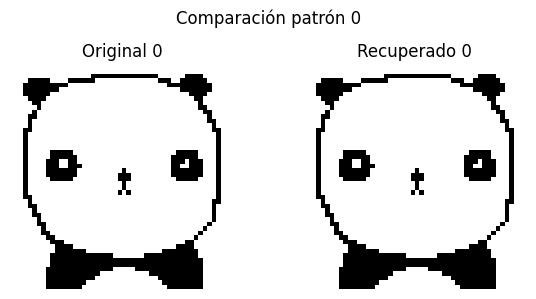

El patrón 1 fue recuperado correctamente.


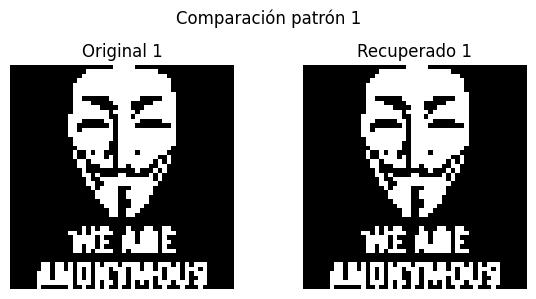

El patrón 2 fue recuperado correctamente.


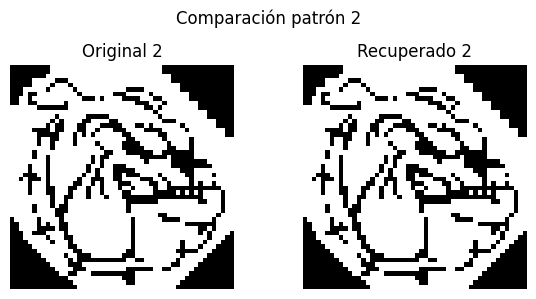

In [25]:
for i in range(len(patrones_vectorizados)):
    patron_original = patrones_vectorizados[i]
    estado_convergido = recuperar_patron(patron_original, pesos, 10000)
    
    if estado_convergido == patron_original:
        print(f"El patrón {i} fue recuperado correctamente.")
    else:
        print(f"El patrón {i} NO se recuperó correctamente.")
    mostrar_comparacion_patron(patron_original, estado_convergido, ancho=50, alto=50, indice=i)



### Prueba con imágenes de 60x45

Se repite el procedimiento anterior utilizando un nuevo conjunto de imágenes de tamaño `60x45`. Se cargan, vectorizan y entrenan en la red de Hopfield. Luego, se verifica si la red es capaz de recuperar correctamente los patrones a partir de sí mismos.

Cada comparación muestra el patrón original y su versión recuperada tras aplicar la dinámica de la red. Esto permite verificar que el modelo puede escalar y seguir funcionando correctamente con imágenes más grandes.


paloma.bmp - tamaño: 60x45
quijote.bmp - tamaño: 60x45
torero.bmp - tamaño: 60x45
Se cargaron 3 patrones de 45 filas y 60 columnas cada uno.
Tengo 3 patrones vectorizados de 2700 elementos cada uno.
El patrón 0 fue recuperado correctamente.


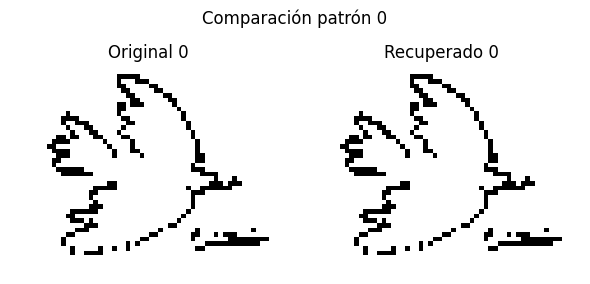

El patrón 1 fue recuperado correctamente.


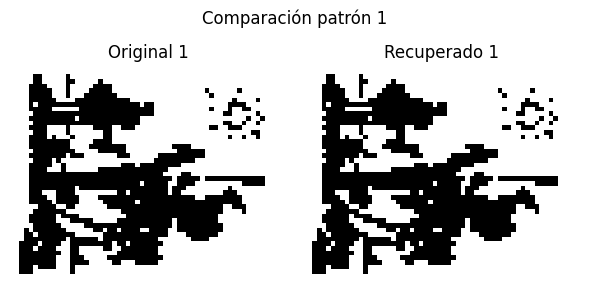

El patrón 2 fue recuperado correctamente.


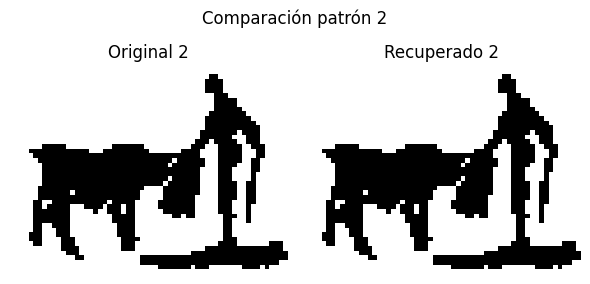

In [26]:
carpeta_imagenes = "imagenes/60x45"
patrones = cargar_patrones_desde_carpeta(carpeta_imagenes)
patrones_vectorizados_imagenes_grandes = centrar_y_vectorizar_patrones(patrones)

ancho = 60
alto = 45
dimension = ancho * alto

pesos_imagenes_grandes = inicializar_matriz_pesos(dimension)
pesos_imagenes_grandes = entrenar_red_hopfield(patrones_vectorizados_imagenes_grandes)

for i in range(len(patrones_vectorizados_imagenes_grandes)):
    patron_original = patrones_vectorizados_imagenes_grandes[i]
    estado_convergido = recuperar_patron(patron_original, pesos_imagenes_grandes, 10000)

    if estado_convergido == patron_original:
        print(f"El patrón {i} fue recuperado correctamente.")
    else:
        print(f"El patrón {i} NO se recuperó correctamente.")
    
    mostrar_comparacion_patron(patron_original, estado_convergido, ancho=ancho, alto=alto, indice=i)


### Agregado de ruido a los patrones

Para evaluar la robustez de la red de Hopfield, se introduce ruido artificial en los patrones antes de presentarlos a la red. La función `agregar_ruido` invierte aleatoriamente un porcentaje de los bits del patrón original (valores `-1` o `1`).

Este proceso simula entradas incompletas o corruptas, y permite comprobar si la red es capaz de recuperar el patrón correcto a pesar del ruido. La proporción de bits alterados se controla mediante el parámetro `porcentaje_ruido`, que puede variar entre `0.0` (sin ruido) y `1.0` (ruido total).


In [27]:
def agregar_ruido(patron, porcentaje_ruido):
    """
    Invierte un porcentaje de bits en el patrón (valores -1/1).
    
    :param patron: vector original (-1 y 1)
    :param porcentaje_ruido: valor entre 0.0 y 1.0 indicando proporción de bits a modificar
    :return: nuevo patrón con ruido
    """
    patron_con_ruido = patron.copy()
    n = len(patron)
    cantidad_ruido = int(n * porcentaje_ruido)

    indices_a_modificar = random.sample(range(n), cantidad_ruido)

    for idx in indices_a_modificar:
        patron_con_ruido[idx] *= -1  # invierte el bit

    return patron_con_ruido


In [28]:
def contar_diferencias(p1, p2):
    """
    Cuenta cuántos bits difieren entre dos patrones del mismo tamaño.
    """
    return sum(1 for a, b in zip(p1, p2) if a != b)


### Evaluación de la tolerancia al ruido

En esta sección se analiza la capacidad de la red de Hopfield para recuperar correctamente los patrones originales a medida que se introduce ruido. Para ello, se prueba con distintos niveles de ruido (de 0% a 100%) invirtiendo aleatoriamente un porcentaje de los bits en cada patrón.

Se calcula el error promedio de recuperación (proporción de bits incorrectos) para cada nivel de ruido. Finalmente, se grafica la precisión de la red como función del ruido, lo cual permite visualizar su comportamiento frente a distorsiones crecientes.

Un buen modelo debería mantener alta precisión para bajos niveles de ruido, degradándose progresivamente a medida que la distorsión aumenta.


In [29]:
def evaluar_robustez_ruido(patrones_vectorizados, pesos, niveles_ruido=None, max_iter=10000):
    """
    Evalúa el desempeño de la red de Hopfield ante distintos niveles de ruido.

    :param patrones_vectorizados: lista de vectores de patrones originales (-1 y 1)
    :param pesos: matriz de pesos entrenada
    :param niveles_ruido: lista de valores entre 0.0 y 1.0 representando niveles de ruido
    :param max_iter: máximo de iteraciones para la convergencia
    :return: lista de errores promedio para cada nivel de ruido
    """
    if niveles_ruido is None:
        niveles_ruido = [i / 10 for i in range(11)]  # de 0.0 a 1.0

    errores_promedio = []

    for ruido in niveles_ruido:
        total_errores = 0
        for patron_original in patrones_vectorizados:
            patron_ruidoso = agregar_ruido(patron_original, ruido)
            estado_convergido = recuperar_patron(patron_ruidoso, pesos, max_iter)
            errores = contar_diferencias(patron_original, estado_convergido)
            total_errores += errores

        promedio = total_errores / (len(patrones_vectorizados) * len(patron_original))
        errores_promedio.append(promedio)
        print(f"Ruido {int(ruido*100)}% → Error promedio: {promedio:.4f}")

    return niveles_ruido, errores_promedio

def graficar_precision_vs_ruido(niveles_ruido, errores_promedio):
    """
    Grafica la precisión de recuperación en función del nivel de ruido.
    
    :param niveles_ruido: lista de niveles de ruido (0.0 a 1.0)
    :param errores_promedio: lista de errores promedio correspondientes
    """
    precisiones = [1 - e for e in errores_promedio]

    plt.figure(figsize=(8, 4))
    plt.plot([r * 100 for r in niveles_ruido], precisiones, marker='o', linestyle='-', color='blue')
    plt.title("Precisión de recuperación vs. nivel de ruido")
    plt.xlabel("Porcentaje de ruido (%)")
    plt.ylabel("Precisión de recuperación")
    plt.ylim(0, 1.05)
    plt.grid(True)
    plt.show()


# Imaganes 50x50

Ruido 0% → Error promedio: 0.0000
Ruido 10% → Error promedio: 0.0000
Ruido 20% → Error promedio: 0.0000
Ruido 30% → Error promedio: 0.0000
Ruido 40% → Error promedio: 0.0000
Ruido 50% → Error promedio: 0.3855
Ruido 60% → Error promedio: 1.0000
Ruido 70% → Error promedio: 1.0000
Ruido 80% → Error promedio: 1.0000
Ruido 90% → Error promedio: 1.0000
Ruido 100% → Error promedio: 1.0000


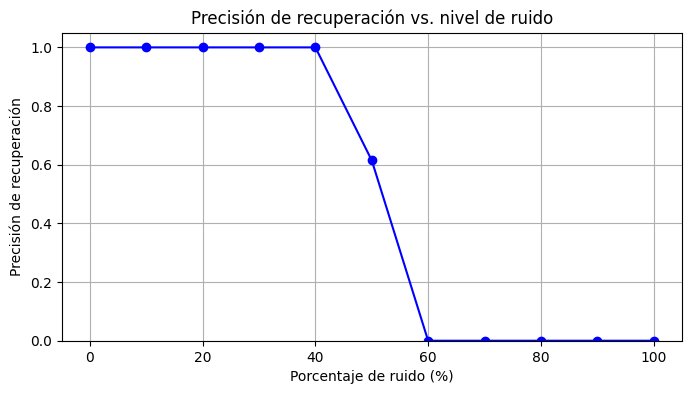

In [30]:
niveles, errores = evaluar_robustez_ruido(patrones_vectorizados, pesos)
graficar_precision_vs_ruido(niveles, errores)


# Imagenes 60x45

Ruido 0% → Error promedio: 0.0000
Ruido 10% → Error promedio: 0.0000
Ruido 20% → Error promedio: 0.0000
Ruido 30% → Error promedio: 0.0000
Ruido 40% → Error promedio: 0.0000
Ruido 50% → Error promedio: 0.3774
Ruido 60% → Error promedio: 1.0000
Ruido 70% → Error promedio: 1.0000
Ruido 80% → Error promedio: 1.0000
Ruido 90% → Error promedio: 1.0000
Ruido 100% → Error promedio: 1.0000


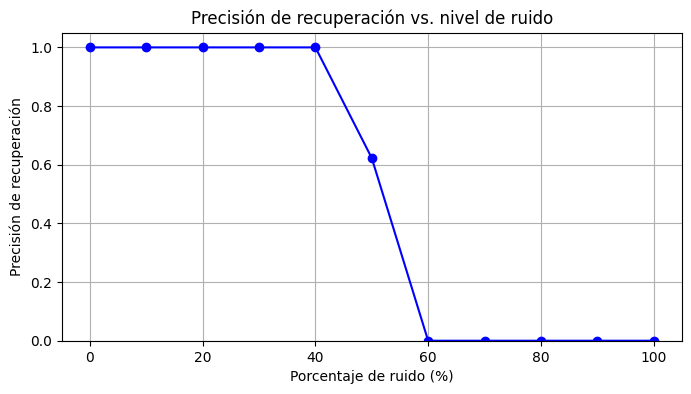

In [31]:
niveles, errores = evaluar_robustez_ruido(patrones_vectorizados_imagenes_grandes, pesos_imagenes_grandes)
graficar_precision_vs_ruido(niveles, errores)


# Punto 3

### Evaluación de estados espurios

En esta celda se prueba la existencia de **estados espurios** en la red de Hopfield entrenada:

- **Patrones invertidos**: se invierte el signo de todos los bits de cada patrón entrenado y se comprueba si el estado permanece estable.
- **Combinaciones impares**: se evalúa la estabilidad del estado resultante de aplicar `sign(P0 + P1 + P2)`.

Si estos estados convergen a sí mismos al ser presentados como entrada a la red, se considera que son **estados espurios estables**. Esta es una propiedad conocida de las redes de Hopfield, especialmente cuando se usan múltiples patrones y hay solapamiento entre ellos.


Por último, se evalúa la existencia de estados espurios del tipo **spin-glass**, que son mínimos locales de la energía que **no se parecen a ningún patrón almacenado** ni a combinaciones de ellos.

Para esto, se generan vectores aleatorios de activación (`-1` y `1`) que actúan como entradas completamente nuevas. Si la red converge a esos mismos estados sin haberlos aprendido, se considera que son **estados espurios del tipo spin-glass**.

Este fenómeno se vuelve más probable a medida que se entrena la red con un mayor número de patrones, lo cual genera interferencias y reduce la capacidad efectiva de almacenamiento.

paloma.bmp - tamaño: 60x45
quijote.bmp - tamaño: 60x45
torero.bmp - tamaño: 60x45
Se cargaron 3 patrones de 45 filas y 60 columnas cada uno.
Tengo 3 patrones vectorizados de 2700 elementos cada uno.

--- Estados inversos ---
Inverso del patrón 0 es un estado espurio estable.


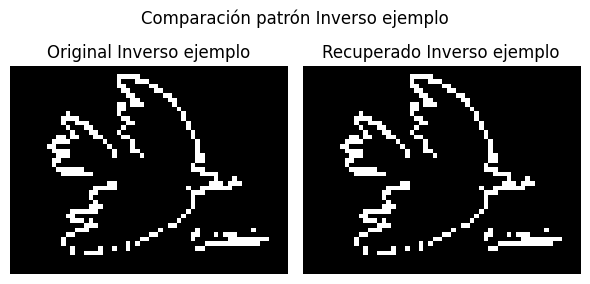

Inverso del patrón 1 es un estado espurio estable.


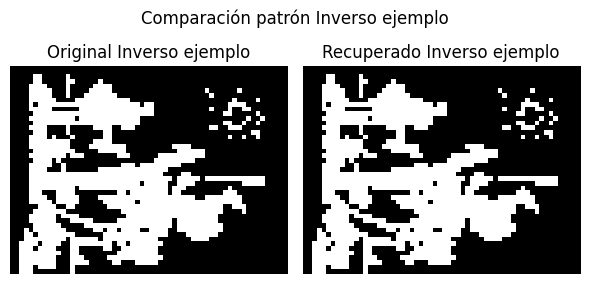

Inverso del patrón 2 es un estado espurio estable.


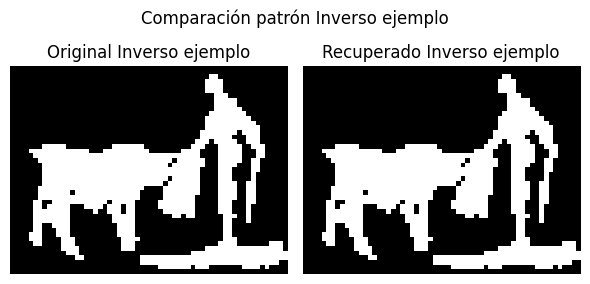


--- Combinación impar de 3 patrones ---
Combinación de P0, P1 y P2 es un estado espurio estable.


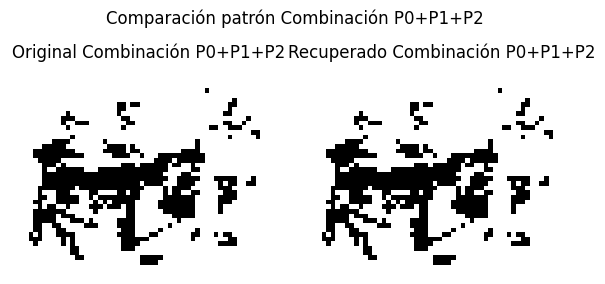

In [36]:
# Cargar imágenes y vectorizarlas
carpeta_imagenes = "imagenes/60x45"
patrones = cargar_patrones_desde_carpeta(carpeta_imagenes)
patrones_vectorizados = centrar_y_vectorizar_patrones(patrones)

ancho, alto = 60, 45
dimension = ancho * alto

# Entrenar la red
pesos = entrenar_red_hopfield(patrones_vectorizados)

# ---------- ESTADOS ESPURIOS ----------

def es_estable(estado, pesos, max_iter=10000):
    """
    Verifica si un estado es un mínimo estable (converge a sí mismo).
    """
    convergido = recuperar_patron(estado, pesos, max_iter)
    return convergido == estado

# 1. Inversos de cada patrón
print("\n--- Estados inversos ---")
for i, patron in enumerate(patrones_vectorizados):
    inverso = [-x for x in patron]
    if es_estable(inverso, pesos):
        print(f"Inverso del patrón {i} es un estado espurio estable.")
    else:
        print(f"Inverso del patrón {i} NO es estable.")
    mostrar_comparacion_patron(inverso, recuperar_patron(inverso, pesos), ancho, alto, indice="Inverso ejemplo")

# 2. Combinación impar de patrones: sign(P0 + P1 + P2)
print("\n--- Combinación impar de 3 patrones ---")

def combinar_patrones(*patrones):
    def signo(x): return 1 if x >= 0 else -1
    return [signo(sum(p[i] for p in patrones)) for i in range(len(patrones[0]))]

if len(patrones_vectorizados) >= 3:
    combinado = combinar_patrones(
        patrones_vectorizados[0],
        patrones_vectorizados[1],
        patrones_vectorizados[2]
    )

    if es_estable(combinado, pesos):
        print("Combinación de P0, P1 y P2 es un estado espurio estable.")
    else:
        print("Combinación de P0, P1 y P2 NO es estable.")
else:
    print("No hay suficientes patrones para probar combinación impar.")

# Opcional: visualizar uno de estos estados espurio
mostrar_comparacion_patron(combinado, recuperar_patron(combinado, pesos), ancho, alto, indice="Combinación P0+P1+P2")



panda.bmp - tamaño: 50x50
v.bmp - tamaño: 50x50
perro.bmp - tamaño: 50x50
Se cargaron 3 patrones de 50 filas y 50 columnas cada uno.
Tengo 3 patrones vectorizados de 2500 elementos cada uno.

--- Estados inversos ---
Inverso del patrón 0 es un estado espurio estable.


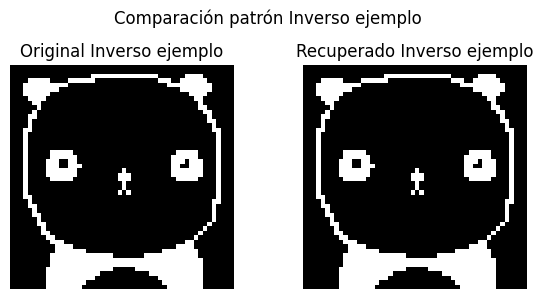

Inverso del patrón 1 es un estado espurio estable.


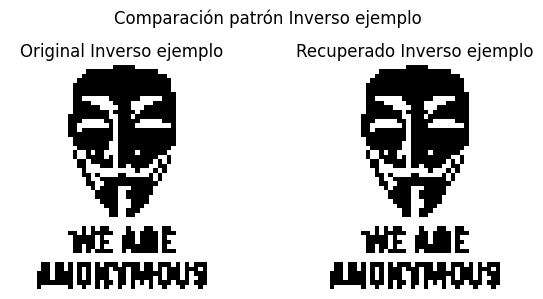

Inverso del patrón 2 es un estado espurio estable.


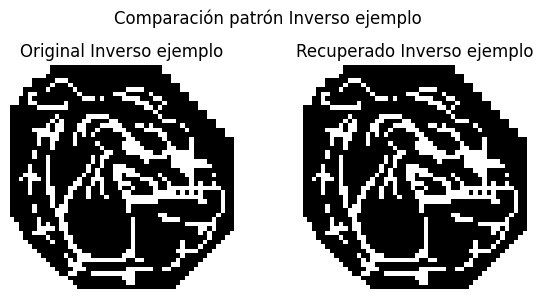


--- Combinación impar de 3 patrones ---
Combinación de P0, P1 y P2 es un estado espurio estable.


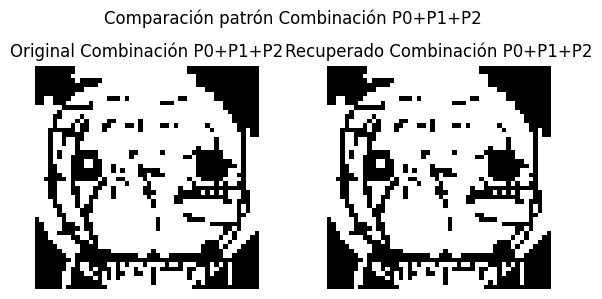


--- Estados tipo spin-glass ---
Estado aleatorio 0 NO es estable.
Estado aleatorio 1 NO es estable.
Estado aleatorio 2 NO es estable.
Estado aleatorio 3 NO es estable.
Estado aleatorio 4 NO es estable.


In [37]:
# Cargar imágenes y vectorizarlas
carpeta_imagenes = "imagenes/50x50"
patrones = cargar_patrones_desde_carpeta(carpeta_imagenes)
patrones_vectorizados = centrar_y_vectorizar_patrones(patrones)

ancho, alto = 50, 50
dimension = ancho * alto

# Entrenar la red
pesos = entrenar_red_hopfield(patrones_vectorizados)

# ---------- ESTADOS ESPURIOS ----------

def es_estable(estado, pesos, max_iter=10000):
    """
    Verifica si un estado es un mínimo estable (converge a sí mismo).
    """
    convergido = recuperar_patron(estado, pesos, max_iter)
    return convergido == estado

# 1. Inversos de cada patrón
print("\n--- Estados inversos ---")
for i, patron in enumerate(patrones_vectorizados):
    inverso = [-x for x in patron]
    if es_estable(inverso, pesos):
        print(f"Inverso del patrón {i} es un estado espurio estable.")
    else:
        print(f"Inverso del patrón {i} NO es estable.")
    mostrar_comparacion_patron(inverso, recuperar_patron(inverso, pesos), ancho, alto, indice="Inverso ejemplo")

# 2. Combinación impar de patrones: sign(P0 + P1 + P2)
print("\n--- Combinación impar de 3 patrones ---")

def combinar_patrones(*patrones):
    def signo(x): return 1 if x >= 0 else -1
    return [signo(sum(p[i] for p in patrones)) for i in range(len(patrones[0]))]

if len(patrones_vectorizados) >= 3:
    combinado = combinar_patrones(
        patrones_vectorizados[0],
        patrones_vectorizados[1],
        patrones_vectorizados[2]
    )

    if es_estable(combinado, pesos):
        print("Combinación de P0, P1 y P2 es un estado espurio estable.")
    else:
        print("Combinación de P0, P1 y P2 NO es estable.")
else:
    print("No hay suficientes patrones para probar combinación impar.")

# Opcional: visualizar uno de estos estados espurios
mostrar_comparacion_patron(combinado, recuperar_patron(combinado, pesos), ancho, alto, indice="Combinación P0+P1+P2")

import random

# 3. Estados tipo spin-glass: aleatorios, no relacionados
print("\n--- Estados tipo spin-glass ---")

def generar_estado_aleatorio(n):
    return [random.choice([-1, 1]) for _ in range(n)]

for i in range(5):  # probar 5 estados aleatorios
    estado_random = generar_estado_aleatorio(dimension)
    if es_estable(estado_random, pesos):
        print(f"Estado aleatorio {i} es un mínimo local estable (posible spin-glass).")
    else:
        print(f"Estado aleatorio {i} NO es estable.")





### Entrenamiento con las 6 imágenes unificadas

Dado que las redes de Hopfield solo permiten patrones de igual tamaño, se redimensionaron todas las imágenes (3 de `60x45` y 3 de `50x50`) al tamaño común de `50x50`.

Esto permitió unificar los datos y entrenar la red con los 6 patrones simultáneamente.

Luego se verificó si la red era capaz de recuperar cada patrón al ser presentado como entrada. Si todos se recuperan correctamente, significa que la red **almacenó exitosamente los 6 patrones**. En caso contrario, la aparición de errores indicaría que la capacidad de almacenamiento se vio superada, o que hubo interferencia entre patrones similares.

Este experimento permite explorar los límites prácticos de la capacidad de memoria de una red de Hopfield clásica.


panda.bmp - tamaño: 50x50
v.bmp - tamaño: 50x50
perro.bmp - tamaño: 50x50
Se cargaron 3 patrones de 50 filas y 50 columnas cada uno.
Tengo 6 patrones vectorizados de 2500 elementos cada uno.

--- Evaluación de recuperación de los 6 patrones ---
❌ Patrón 1 NO fue recuperado.


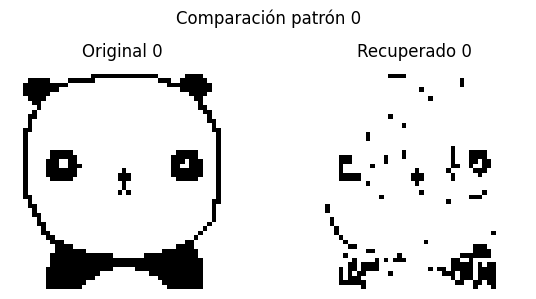

✅ Patrón 2 fue recuperado correctamente.


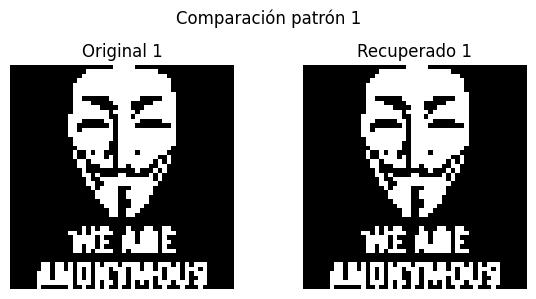

✅ Patrón 3 fue recuperado correctamente.


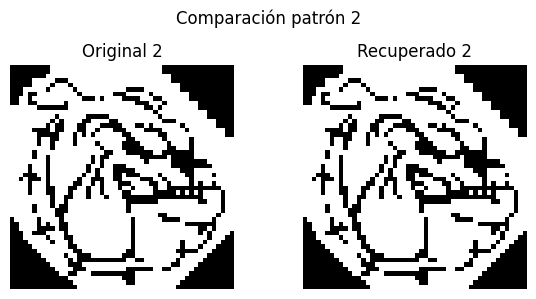

❌ Patrón 4 NO fue recuperado.


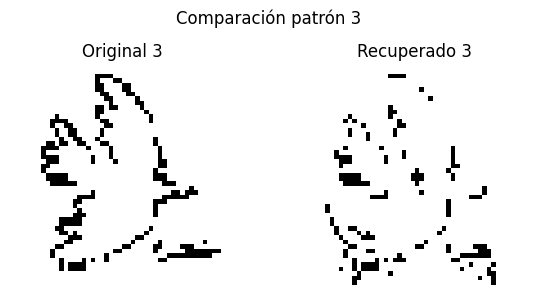

✅ Patrón 5 fue recuperado correctamente.


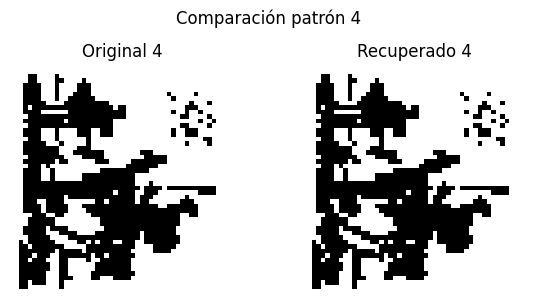

✅ Patrón 6 fue recuperado correctamente.


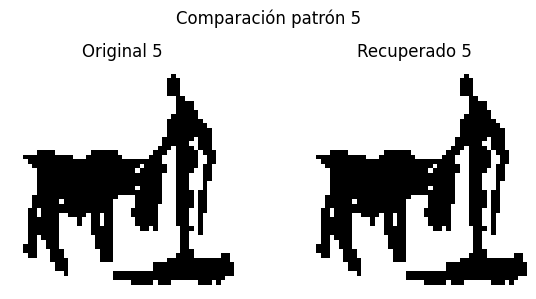

In [ ]:
from PIL import Image
import os

# Cargar imágenes 50x50
patrones_50 = cargar_patrones_desde_carpeta("imagenes/50x50")

# Cargar imágenes 60x45 redimensionadas a 50x50
def cargar_redimensionadas(carpeta, nuevo_tamaño=(50, 50)):
    patrones = []
    archivos = [f for f in os.listdir(carpeta) if f.endswith(".bmp")]
    for archivo in archivos:
        ruta = os.path.join(carpeta, archivo)
        img = Image.open(ruta).convert("1").resize(nuevo_tamaño)
        binario = [[1 if img.getpixel((x, y)) == 255 else 0 for x in range(nuevo_tamaño[0])] for y in range(nuevo_tamaño[1])]
        patrones.append(binario)
    return patrones

patrones_60 = cargar_redimensionadas("imagenes/60x45", (50, 50))

# Unificamos y vectorizamos
patrones_unificados = patrones_50 + patrones_60
patrones_vectorizados = centrar_y_vectorizar_patrones(patrones_unificados)

# Entrenamiento
ancho, alto = 50, 50
pesos = entrenar_red_hopfield(patrones_vectorizados)

print("\n--- Evaluación de recuperación de los 6 patrones ---")
for i, patron in enumerate(patrones_vectorizados):
    recuperado = recuperar_patron(patron, pesos, 10000)
    dif = contar_diferencias(patron, recuperado)
    total = len(patron)
    similitud = 1 - dif / total

    if dif == 0:
        print(f"✅ Patrón {i} fue recuperado exactamente.")
    else:
        print(f"🔍 Patrón {i} fue recuperado con similitud del {similitud*100:.2f}% ({dif} bits distintos).")

    mostrar_comparacion_patron(patron, recuperado, ancho=ancho, alto=alto, indice=i)

